In [101]:
import os
import datetime

from utils.visualization import plot_predictions

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sqlalchemy import create_engine, sql

# matplotlib settings
mpl.rcParams["figure.figsize"] = (12, 3)
mpl.rcParams["axes.grid"] = False

# constnats
PRINT_RED = '\033[91m'

#--------------------------------------------------------------------------
# Database connection setup
#--------------------------------------------------------------------------

# get postgres environment variables
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB_NAME = os.getenv("PG_DB_NAME")
PG_USERNAME = os.getenv("PG_USERNAME")
PG_PASSWORD = os.getenv("PG_PASSWORD")

# check for missing environment variables
if PG_HOST == None or PG_PORT == None or PG_DB_NAME == None or PG_USERNAME == None or PG_PASSWORD == None:
    print(f'{PRINT_RED}[ ERROR ] Environment variables PG_HOST, PG_PORT, PG_DB_NAME, PG_USERNAME, or PG_PASSWORD not found.')

# hard-code table name
PG_TABLE = "bars_minute_eastern"

# connect to db and open a cursor to perform database operations
conn_string = f"postgresql://{PG_USERNAME}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB_NAME}"
db = create_engine(conn_string)
conn = db.connect()

In [102]:
#------------------------------------------------------------------------------
# Pull data from db and wrangle into correct shape
# (minute bars for NVDA from 09:00-14:00 from 2022/06/01-2022/07/01)
#------------------------------------------------------------------------------

# create empty dataframe to hold bar data
days_data_df = pd.DataFrame(columns=["date", "minute_bars"])

# create empty dataframe to hold timestamp data
days_timestamps_df = pd.DataFrame(columns=["date", "timestamp"])

# NOTE: db contains minute bars for NVDA,INTC from 2022/06/01 to 2022/07/01 (inclusive)
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 7, 1)

# loop over each date and get minute_bars from db
current_date = start_date
day_delta = datetime.timedelta(days=1)
while current_date <= end_date:
    # pull minute_bars for current_date
    day_minute_bars_df = pd.read_sql_query(
        sql=sql.text(f"select * from { PG_TABLE } where SYMBOL='NVDA' and date(TIMESTAMP)='{ current_date }'"),
        con=conn,
    )

    # add minute_bars to days_df if there is bar data
    if not day_minute_bars_df.empty:
        # drop symbol column
        day_minute_bars_df.drop("symbol", axis=1, inplace=True)

        # drop volume column
        day_minute_bars_df.drop("volume", axis=1, inplace=True)

        #----------------------------------------------------------------------
        # Convert timestamps to day/week/year sin and cosine signals
        #----------------------------------------------------------------------

        # extract timestamps
        timestamps = pd.to_datetime(day_minute_bars_df.pop("timestamp"))

        timestamp_s = timestamps.map(pd.Timestamp.timestamp)

        seconds_per_day = 24 * 60 * 60
        seconds_per_week = seconds_per_day * 7
        seconds_per_year = seconds_per_week * 52.1429

        day_minute_bars_df["day-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_day))
        day_minute_bars_df["day-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_day))

        day_minute_bars_df["week-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_week))
        day_minute_bars_df["week-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_week))

        day_minute_bars_df["year-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_year))
        day_minute_bars_df["year-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_year))

        # insert day minute bars and timestamps to their respecive dataframes
        days_data_df.loc[len(days_data_df), days_data_df.columns] = current_date, day_minute_bars_df
        days_timestamps_df.loc[len(days_timestamps_df), days_timestamps_df.columns] = current_date, timestamps

    # go to next day
    current_date += day_delta

In [103]:
# -----------------------------------------------------------------------------
# Split into training/validation (70%), validation (20%), and test (10%) sets
# -----------------------------------------------------------------------------

n = len(days_data_df)  # total number of days

days_train_df = days_data_df[0 : int(n * 0.7)]
days_val_df = days_data_df[int(n * 0.7) : int(n * 0.9)]
days_test_df = days_data_df[int(n * 0.9) :]

In [127]:
#-----------------------------------------------------------------------------
# Create and train a convolutional model
#-----------------------------------------------------------------------------

N_FEATURES = len(days_data_df.iloc[0]['minute_bars'].columns)
INPUT_WINDOW_LEN = 10
BATCH_SIZE = 128 # not much clue what this does
CONV_WIDTH = 3 # no clue what this does
EPOCHS = 50 # no clue what this does
FILTERS = 32 # no clue what this does

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=CONV_WIDTH, activation='relu', input_shape=(INPUT_WINDOW_LEN, N_FEATURES)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear'),
    
    # Shape: (time, features) => (time*features)
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dense(units=1),
    # # Add back the time dimension.
    # # Shape: (outputs) => (1, outputs)
    # tf.keras.layers.Reshape([1, -1]),
])

conv_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), # Computes the mean of squares of errors between labels and predictions.
    optimizer=tf.keras.optimizers.Adam(), # Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    metrics=[tf.keras.metrics.MeanAbsoluteError()], # Computes the mean of absolute difference between labels and predictions.
)

In [128]:
# loop over training days to fit the model
for index, day_data in days_train_df.iterrows():
    print(days_data_df.iloc[index]['date'])

    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    targets = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN:]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]

    # Fit the model to the training data
    conv_model.fit(
        x=minute_bars_windows,
        y=targets,
        epochs=EPOCHS,
        verbose=1,
        batch_size=BATCH_SIZE,
    )

2022-06-01
Epoch 1/50


2023-04-28 17:23:32.111542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 53ms/step - loss: 10085.4619 - mean_absolute_error: 97.8967
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 444.6976 - mean_absolute_error: 17.2586
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 1099.3837 - mean_absolute_error: 32.9209
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 888.4892 - mean_absolute_error: 29.4079
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 55.2335 - mean_absolute_error: 6.0668
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 213.7266 - mean_absolute_error: 14.4096
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 253.9066 - mean_absolute_error: 15.8229
Epoch 8/50
4/4 [==============================] - 0s 7ms/step - loss: 29.2944 - mean_absolute_error: 4.5881
Epoch 9/50
4/4 [==============================] - 0s 7ms/step - loss: 52.5209 - mean_absolute_error: 7.0284
Epoch 10/50
4/4 [====

2023-04-28 17:24:09.316745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.4214160740375519, Test MAE: 0.46140098571777344
(411, 1)


2023-04-28 17:24:09.529090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


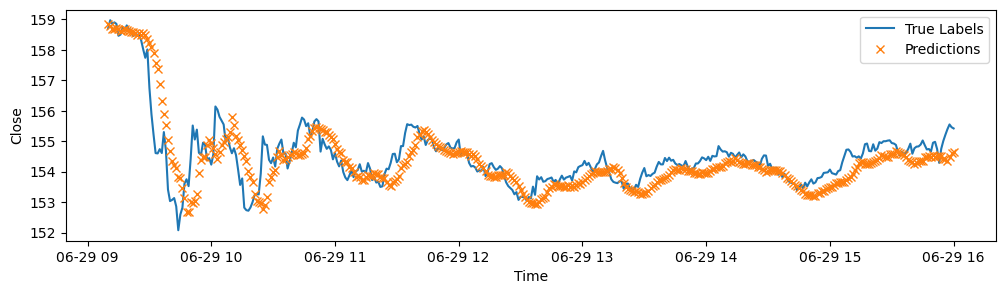

Test loss: 0.5240169763565063, Test MAE: 0.5975863933563232
(411, 1)


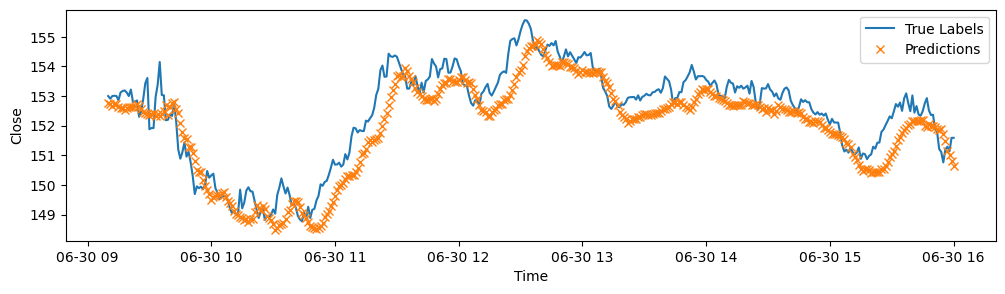

Test loss: 0.3747127056121826, Test MAE: 0.49929749965667725
(411, 1)


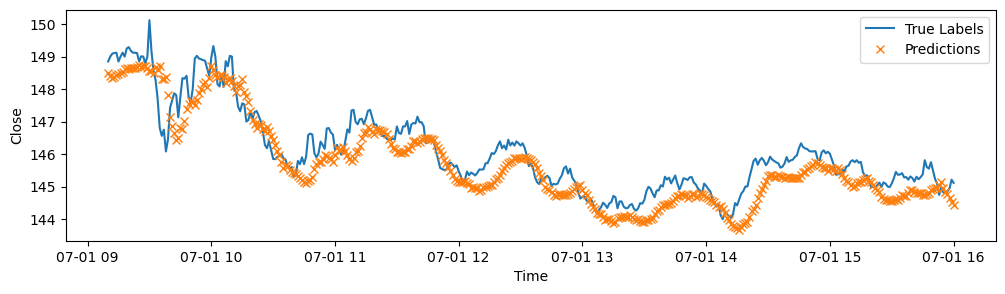

In [129]:
for index, day_data in days_test_df.iterrows():
    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    targets = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN:]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]
    
    # Evaluate the model on the test data
    loss, mae = conv_model.evaluate(x=minute_bars_windows, y=targets, verbose=0)
    print(f"Test loss: {loss}, Test MAE: {mae}")
    
    predictions = conv_model.predict(x=minute_bars_windows, verbose=0, steps=None)

    print(predictions.shape)  # (391, 1)

    # predictions = np.reshape(predictions, (391,))

    timestmpasasdf = days_timestamps_df.iloc[index]['timestamp'].values[INPUT_WINDOW_LEN:]

    plot_predictions(labels=targets, predictions=predictions, timestamps=timestmpasasdf)